### Understand the impact of modeling phase correlations using GP kernels

We use a smooth kernel to represent the correlation between spectra at two locations in our design space i.e. `k(c1, c2)`.
The idea here is that, these correlations capture the underlying phasemap characteristics as well as they can based on the collected data. 
We can then use these correlations and use a bigger neural network to make a prediction of the full spectrum at any given location.

The kernel is supposed to encode the following:

    1. If a phase is identified by a spectrum that does not change the peak position but only the width, then the value of $$k(c1, c2)$$ when $c1, c2 \in phase$ should only result in corresponding changes.
    
    2. If a phase is identified by a single spectrum with no changes, then the value of `k(c1, c2)` should be same across the corresponding phase region.

In [42]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize
from activephasemap.utils.settings import initialize_model
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import get_twod_grid
import gpytorch

import json, math

USE_NOISE = False

## Simple Multi-Task GP model

In [43]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
gp_model_args = {"model":"gp", "num_epochs" : 50, "learning_rate" : 1e-1, "verbose": 10}
model = initialize_model(train_x, train_y, gp_model_args, 1, 2, device)
model.fit()
test_x = torch.linspace(0, 1, 51)
model.gp.eval()
model.mll.eval()

if USE_NOISE:
    posterior = model.gp.likelihood(model.gp(test_x))
else:
    posterior = model.gp(test_x)

with gpytorch.settings.prior_mode(True):
    if USE_NOISE:
        prior = model.gp.likelihood(model.gp(test_x))
    else:
        prior = model.gp(test_x)

Epoch   1/50 - Loss: 1.097 
Epoch  11/50 - Loss: 0.467 
Epoch  21/50 - Loss: 0.215 
Epoch  31/50 - Loss: 0.039 
Epoch  41/50 - Loss: 0.030 
Epoch  50/50 - Loss: 0.030 


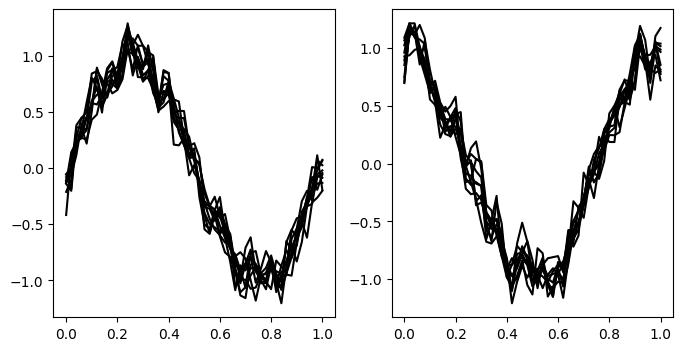

In [44]:
def plot_samples_1d(dist, num_samples):
    fig, axs = plt.subplots(1,2, figsize=(4*2, 4))
    for _ in range(num_samples):
        z_sample = dist.sample()
        for i, ax in enumerate(axs):
            zi = z_sample[:,i].squeeze()
            ax.plot(test_x, zi, color="k")
    plt.show()

plot_samples_1d(posterior, 10)

We can see that the posterior samples from GP have some structure learnt by data samples `(train_x, train_y)` as opposed to prior samples below, that have just some continuous structure. We can turn off the likelihood on these models to see much smoother versions of these function samples.

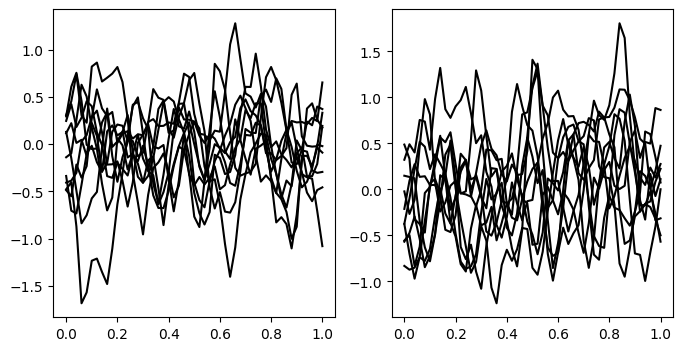

In [45]:
plot_samples_1d(prior, 10)

## GP Model for phase map

### Samples from prior

In [37]:
ITERATION = 6
DATA_DIR = "./04012024/2D/"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]
with open('./04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
model = initialize_model(normalized_x, train_y, gp_model_args, expt.dim, N_LATENT, device)
C_grid = get_twod_grid(20, expt.bounds.cpu().numpy())
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
model.load_state_dict(gp_state_dict)

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Loading data from iteration 3 with shapes: (8, 2) (8, 101)
Loading data from iteration 4 with shapes: (8, 2) (8, 101)
Loading data from iteration 5 with shapes: (8, 2) (8, 101)


<All keys matched successfully>

In [38]:
test_x = torch.from_numpy(C_grid).to(train_x).reshape(len(C_grid),1,2)

model.gp.eval()
model.mll.eval()
posterior = model.gp.likelihood(model.gp(test_x))

with gpytorch.settings.prior_mode(True):
    prior = model.gp.likelihood(model.gp(test_x))

### Posterior Samples

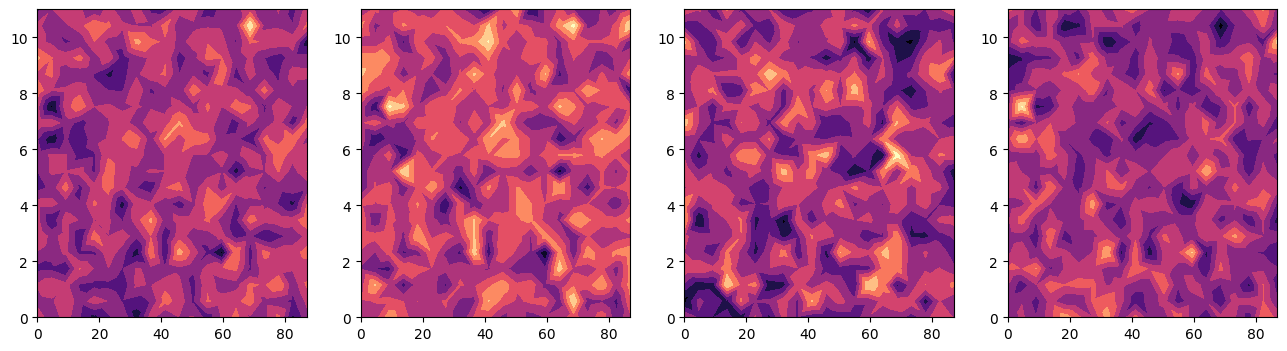

In [39]:
from matplotlib.colors import Normalize
from matplotlib import colormaps 

def plot_samples_2d(dist, num_samples=1):
    cmap = colormaps["magma"]
    for _ in range(num_samples):
        z_sample = dist.sample()
        fig, axs = plt.subplots(1,N_LATENT, figsize=(4*N_LATENT, 4))
        for i, ax in enumerate(axs):
            zi = z_sample[:,:,i].squeeze()
            norm = Normalize(vmin=min(zi), vmax = max(zi))
            ax.tricontourf(C_grid[:,0],
                           C_grid[:,1],
                           zi, 
                           cmap=cmap, norm=norm
                        )
        plt.show()

plot_samples_2d(posterior)

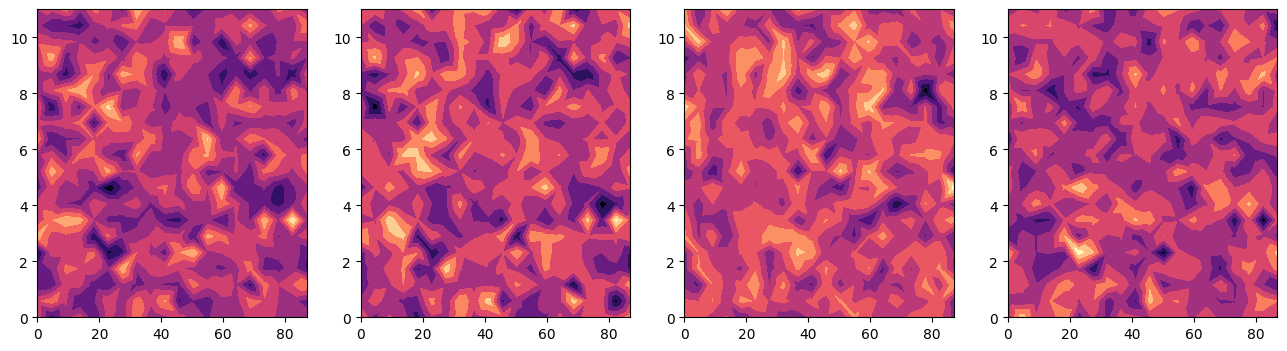

In [40]:
plot_samples_2d(prior)

One reason for not seeing any structure is that the latent variables have no direct correlation to features of the spectrum that can be identified with a particular morphology such as the peak position, number of peaks, peak intensity etc. This is a common scenario in encoder-decoder like models and we anticiapte that this is also occuring in this work. 

In an ideal case scenario, the posterior samples of latent variables would be much structured and we can directly extract the phasemap via spatial correlations between the design space variables. 